# Deep Q-Network (40分)
同学们好，在这个notebook中，你将学会如何使用DQN算法来完成一个简单的电脑游戏，本Notebook包含的如下：
1. [**准备工作**](#1.准备工作)
    * 导入依赖库
2. [**实现DQN的主要部件**](#2.DQN的主要部件)
    * ReplayBuffer (经验池)
    * Q-Network
    * Epsilon-greedy策略
    * 收集Transitions
3. [**编写DQN的完整训练流程**](#3.编写DQN的完整训练流程)
    * DQN一步梯度更新
    * DQN完整训练流程
4. [**在游戏环境中实践DQN**](#4.在游戏环境中实践DQN)
    * 训练DQN
    * 测试DQN
    * 保存模型
**提醒：本次作业使用CPU即可** 
# 1.准备工作
## 1.1 导入依赖库

In [18]:
!pip install gymnasium[classic-control] > /dev/null 2>&1

In [19]:
from typing import Optional, Type, Union
from gymnasium import spaces
from tqdm import tqdm
from dataclasses import dataclass

import numpy as np
import gymnasium as gym
import torch.nn as nn
import torch
import imageio
import warnings
import matplotlib.pyplot as plt
import sys
sys.path.append('/kaggle/input/hw4-rl/')
from test_dqn import *
from dqn_utils import evaluate_policy, record_video, show_video

# 过滤所有警告
warnings.filterwarnings("ignore")

# 2.DQN的主要部件
## 2.1 经验池（Replay Buffer）
经验池（replay buffer）是DQN的主要组成部分之一，它包含一系列的经验（transition），其功能类似于之前学习的监督学习中的数据集。其中包含两个重要的操作：
- `store_transition`: 向Relay Buffer中存入一条transition
- `sample`: 从Replay Buffer中取出一批transitions用于训练

<div style="text-align:center;">
    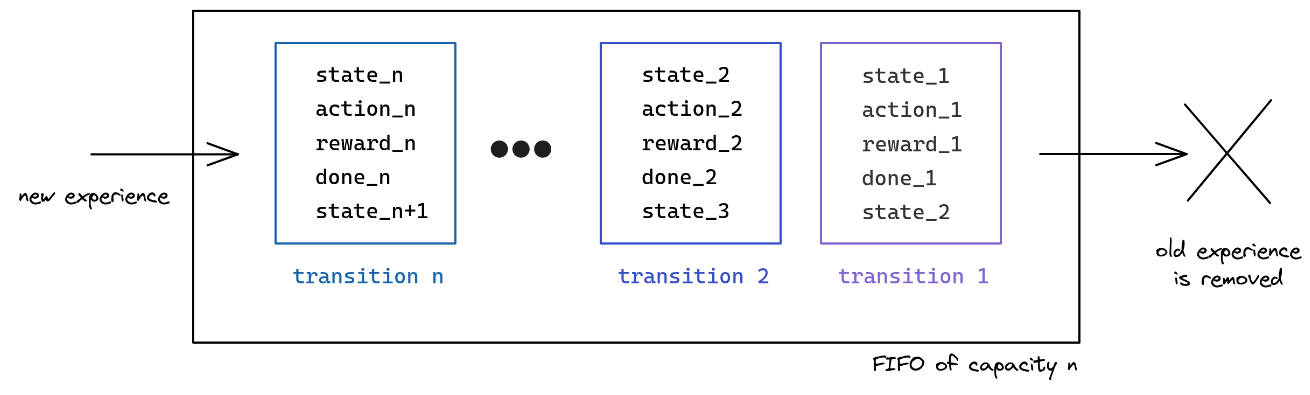
</div>

从上面的图中我们可以看到，**DQN中的数据的单元是transition**，每一条transition是一个五元组：\
`observation, action, reward, next_observation, terminated` \
其中observation等同于环境状态state；terminated用于标识该回合是否结束，即next_state是否是游戏的结束状态。 \
在python中我们用下面的数据类来定义一个batch的transitions:

In [20]:
@dataclass
class TorchBatchTransitions:
    """
    ReplayBuffer中一个batch的transitions (数据类型为torch.tensor)
    """
    observations: torch.Tensor
    next_observations: torch.Tensor
    actions: torch.Tensor
    rewards: torch.Tensor
    terminateds: torch.Tensor

@dataclass
class BatchTransitions:
    """
    ReplayBuffer中一个batch的transitions (数据类型为np.ndarray)
    """
    observations: np.ndarray
    next_observations: np.ndarray
    actions: np.ndarray
    rewards: np.ndarray
    terminateds: np.ndarray

    def to_torch(self, device: str = "cpu") -> TorchBatchTransitions:
        """
        将数据从numpy转为tensor格式
        """
        return TorchBatchTransitions(
            observations=torch.as_tensor(self.observations, device=device),
            next_observations=torch.as_tensor(self.next_observations, device=device),
            actions=torch.as_tensor(self.actions, device=device),
            rewards=torch.as_tensor(self.rewards, device=device),
            terminateds=torch.as_tensor(self.terminateds, device=device))

### 代码填空1 (10分): ReplayBuffer
大家需要实现ReplayBuffer中的两个重要的操作：
- `store_trainsition`: 
向Buffer中存入一条transition `(observation, next_observation, action, reward, terminated)`，当达到buffer最大容量时移除最早存入的transition（First In First Out，FIFP）
- `sample`: 
从Replay Buffer中随机采样一个batch的transition，用于模型训练 

提示：[np.random.rand](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html)

In [21]:
class ReplayBuffer:
    """
    Replay Buffer类，支持存储和采样transitions.
    Args:
        `buffer_size`: buffer的容量，允许存储的最大transitions数
        `observation_space`: 环境中的状态空间,包含了状态的数据类型（type）的形状(shape)
        `action_space`: 环境中的动作空间,包含了允许的动作数量
    """
    def __init__(
        self,
        buffer_size: int,
        observation_space: spaces.Box,
        action_space: spaces.Discrete,
    ) -> None:
        # `current_idx`是当前可以插入transition的位置
        # 当buffer没满时指向第一个空位置；当buffer满后指向buffer中最早插入的transition（被新插入的transition覆盖）
        self.current_idx = 0
        # Replay buffer最大容量，整个buffer按照一个**环形**组织，达到最大容量后按照FIFO原则移除旧的transitions
        self.buffer_size = buffer_size
        # 指示buffer是否已满，后续会用到这个标识符
        self.is_full = False
        # 创建五个不同的buffer，并初始化各buffer    
        self.observations = np.zeros((buffer_size, *observation_space.shape), dtype=observation_space.dtype)
        self.next_observations = np.zeros((buffer_size, *observation_space.shape), dtype=observation_space.dtype)
        self.actions = np.zeros((buffer_size, 1), dtype=action_space.dtype)
        self.rewards = np.zeros((buffer_size,), dtype=np.float32)
        self.terminateds = np.zeros((buffer_size,), dtype=bool)

    def store_transition(
        self,
        obs: np.ndarray,
        next_obs: np.ndarray,
        action: int,
        reward: float,
        terminated: bool,
    ) -> None:
        """
        往Buffer中存储一条transition五元组
        obs: 当前状态
        next_obs: 执行动作后环境的下一状态
        action: 当前状态obs下执行的动作
        reward: 执行动作action得到的奖励
        terminated: 指示是否是回合的结束
        """        
        ### YOUR CODE HERE >>>>>>>>>>>>>>>>>>
        # TODO-1. 在__init__中初始化的各个buffer中存入最新的transition
        # 提示：存储的位置为self.current_idx
        #根据输入初始化self的成员
        self.observations[self.current_idx] = obs
        self.next_observations[self.current_idx] = next_obs
        self.actions[self.current_idx] = action
        self.rewards[self.current_idx] = reward
        self.terminateds[self.current_idx] = terminated
        
        # TODO-2. 更新指针`self.current_idx`，注意：
        #    1) 整个buffer是按照环形组织的，当指针达到buffer的末尾后需要重新从0开始.
        #    2) 当buffer满后需要设置`self.is_full`标志为True
        #因为是环形，所以需要取余
        self.current_idx = (self.current_idx + 1) % self.buffer_size
        if self.current_idx == 0:
            self.is_full = True
        
        ### END OF YOUR CODE <<<<<<<<<<<<<<<<<<
    
    def sample(self, batch_size: int) -> BatchTransitions:
        """
        从buffer中采样大小为batch_size的一批transitions
        Args:
            `batch_size`: 批次大小
        Return: 
            从buffer中随机采样的一批transitions，按照BatchTransitions数据格式进行组织并返回
        """
        ### YOUR CODE HERE >>>>>>>>>>>>>>>>>>
        # TODO-1: 确定采样可以达到的最大下标位置upper_bound
        # 提示：当buffer满后是`self.buffer_size`，没满时是最后一个有存有数据的位置
        #最后一个有效处是self.current_idx
        upper_bound = self.buffer_size if self.is_full else self.current_idx

        # TODO-2: 从区间[0, upper_bound]区间采样`batch_size`个索引，提示：
        # 1) 需要支持重复采样，即同一个索引允许被采到多次，这样可以支持batch_size大于buffer_size的情况
        # 2）可以使用np.random.randint函数，但需要注意左右边界的开闭情况
        batch_indices = np.random.randint(0, upper_bound, size=batch_size)
        
        ### END OF YOUR CODE <<<<<<<<<<<<<<<<<<
        
        assert batch_indices.size == batch_size, 'batch_indices的大小不等于batch_size'
        return BatchTransitions(self.observations[batch_indices],
                                self.next_observations[batch_indices],
                                self.actions[batch_indices],
                                self.rewards[batch_indices],
                                self.terminateds[batch_indices])

### 测试代码1：ReplayBuffer
请运行下面代码对你的函数进行初步测试，但该测试代码只能发现常见的问题，并不能保证你的函数所有部分均正确！

In [22]:
test_replay_buffer(ReplayBuffer)

代码通过测试，请注意：
该测试只能发现助教总结的常见问题，通过该测试并不代表你的代码中不存在bug，如果后续训练过程无法收敛需要进一步检查！


## 2.2 Q-Network
Q-Network是DQN中另一个重要的部分，它的作用相当于Q-Learning中的Q-Table，区别在于这里使用神经网络来拟合一个复杂的Q-Function. Q-Network的输入是一个状态observation（也叫state），输出则是当前状态下执行各动作的Q-values（相当于Q-Table中的一行）。如下图所示，如果环境中包含两个可能的动作（left/right）对于状态state，网络将输出在状态state下执行这两个动作的价值Q(state,left) / Q(state,right)。需要注意的是，**Q-Network只是对Q-Values的一种近似或预测**，我们希望通过训练能够较好地拟合真实的Q-values.
<div style="text-align:center;">
    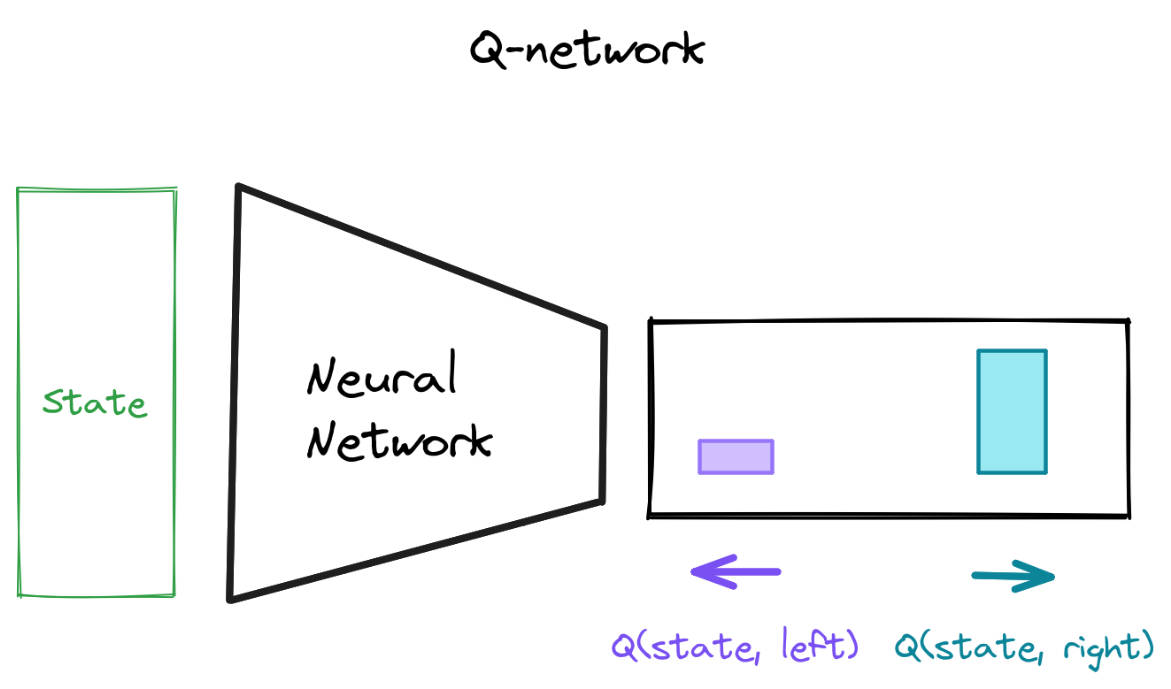
</div>

下面我们将实现一个简单的Q-Network架构，一共包含三个全连接层：
### 代码填空2：Q-Network（10分）
提示：[torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

In [23]:
class QNetwork(nn.Module):
    """
    Q-Network，用于预测给定状态下所有动作的Q-Values
    Args:
        state_space: 环境的状态空间，包含了状态的类型(type)和形状(shape)等信息
        action_space: 环境的动作空间，包含了可能的动作数等信息
        n_hidden_units: 网络中间隐藏层的节点数
        activation_fn: 非线性激活函数 (默认使用ReLU)
    """
    def __init__(
        self,
        observation_space: spaces.Box,
        action_space: spaces.Discrete,
        n_hidden_units: int = 64,
        activation_fn: Type[nn.Module] = nn.ReLU,
    ) -> None:
        super().__init__()
        # 状态的维度（已经展平为1维），这是网络的输入层节点数
        obs_dim = observation_space.shape[0]
        # 环境中的可能动作数，这是网络输出层的节点数
        action_dim = int(action_space.n)
        
        ### YOUR CODE HERE >>>>>>>>>>>>>>>>>>
        # TODO 构建Q-Network:
        # 你需要构建这三个全连接层，明确每一层的输入输出的维度大小(节点个数)
        # 提示1：使用`torch.nn.Linear()`，其中bias默认为True即可
        # 提示2：第一层的输入大小等于状态的维度，最后一层的输出大小等于动作数，中间隐藏层的维度是`n_hidden_units`
        self.fc_1 = nn.Linear(obs_dim, n_hidden_units)
        self.fc_2 = nn.Linear(n_hidden_units, n_hidden_units)
        self.fc_3 = nn.Linear(n_hidden_units, action_dim)
        ### END OF YOUR CODE <<<<<<<<<<<<<<<<<<
        
        self.activation_fn = activation_fn()

    def forward(self, observations: torch.Tensor) -> torch.Tensor:    
        """
        Args:
            observations: 一个批次的状态, 形状(batch_size, obs_dim)
        Return: 
            给定状态observarions下所有动作的Q-values，形状(batch_size, action_dim)
        """
        ### YOUR CODE HERE >>>>>>>>>>>>>>>>>>
        # TODO: 完成网络的前向传播
        # 提示：input(observations) -> fc_1 -> activation_fn -> fc_2 -> activation_fn -> fc_3 -> output(q-values)
        x = self.fc_1(observations)
        x = self.activation_fn(x)
        x = self.fc_2(x)
        x = self.activation_fn(x)
        output = self.fc_3(x)
        
        ### END OF YOUR CODE <<<<<<<<<<<<<<<<<<
        
        return output

### 测试代码2：Q-Network
请运行下面代码对你编写的Q-Network进行初步测试

In [24]:
test_qnetwork(QNetwork)

代码通过测试
请注意：该测试只能发现助教总结的常见问题，通过该测试并不代表你的代码中不存在bug，如果后续训练过程无法收敛需要进一步检查！


## 2.3 Epsilon-greedy策略
和Q-Learning中一样，DQN中同样使用了Epsilon-greedy策略来实现对探索和利用的权衡，具体定义如下：
* 以 1 - ɛ 的概率: 进行利用(exploitation) (按照greedy策略选择给定状态下价值最高的动作).
* 以 ɛ 的概率: 进行探索(exploration) (随机选择一个动作). \
其中epsilon叫做探索率，即exploration rate

### 代码填空3：Epsilon-greedy（5分）
提示：[torch.argmax](https://pytorch.org/docs/stable/generated/torch.argmax.html)

In [25]:
def epsilon_greedy_action_selection(
    q_net: QNetwork,
    observation: np.ndarray,
    exploration_rate: float,
    action_space: spaces.Discrete,
) -> int:
    """
    按照epsilon-greedy策略选择状态observation下需要执行的动作
    Args:
        q_net: Q-Network，用于估计Q-values, 相当于Q-Learning中的Q-Table
        observation: 当前的状态
        exploration_rate: 用于权衡探索和利用的概率 ([0, 1])，即探索率epsilon
        action_space: 环境的动作空间
    Return:
        action: 按照epsilon-greedy策略选出的动作
    """
    random_seed = np.random.rand()
    
    # 进行探索（从动作空间随机选择一个动作）
    if random_seed < exploration_rate:
        # 从动作空间随机选择一个动作
        action = action_space.sample()
    # 进行利用（按照greedy策略选择价值最高的动作）
    else:
        with torch.no_grad():
            # 将np.ndarray的数据转为torch.tensor，并在batch维度上拓展为1
            obs_tensor = torch.as_tensor(observation[np.newaxis, ...]) # 这里的...是函数中需要的参数，不用填空，从下一行开始填即可
    ### YOUR CODE HERE >>>>>>>>>>>>>>>>>>
            # 计算所有动作对应的Q-values, 相当于Q-Learning中Q-Table的一行
            # 提示：使用Q-Network计算
            q_values = q_net(obs_tensor)
            # 按照greedy策略，选择q_values中价值最大的动作
            # 提示：`torch.argmax()`
            action = torch.argmax(q_values, dim=1).item()
    ### END OF YOUR CODE <<<<<<<<<<<<<<<<<<
    
    action = int(action)
    return action

### 测试代码3：epsilon-greedy
请运行下面代码对epsilon-greedy策略进行初步测试

In [26]:
test_epsilon_greedy(QNetwork, epsilon_greedy_action_selection)

代码通过测试
请注意：该测试只能测试epsilon—greedy函数是否能正常运行，不能发现其中的逻辑错误，如果后续训练过程无法收敛需要进一步检查！


**调整探索率epsilon大小** \
在训练过程中需要对epsilon的大小进行调整，使得前期倾向于探索未知的环境，后期倾向于对已知的经验进行利用

In [27]:
def linear_schedule(initial_value: float, final_value: float, current_step: int, max_steps: int) -> float:
    """
    在训练过程中逐步调整探索率epsilon，在训练初期倾向于探索，后期倾向于利用
    """
    progress = current_step / max_steps
    progress = min(progress, 1.0)
    current_value = initial_value + progress * (final_value - initial_value)
    return current_value

## 2.4 向ReplayBuffer中存入一条transition
在给定状态observation下，我们按照epsilon-greedy选择一个动作action；随后执行action，这时环境会返回对执行该动作的即时奖励reward，以及执行该动作后环境的下一个状态next_observation，以及回合是否中止的标识符terminated。这些数据构成了一条transition，然后需要将这各transition存入导ReplayBuffer中用于后续的模型训练
### 代码填空4：收集transition（5分）

In [28]:
def collect_one_transition(
    env: gym.Env,
    q_net: QNetwork,
    replay_buffer: ReplayBuffer,
    obs: np.ndarray,
    exploration_rate: float = 0.1
) -> np.ndarray:
    """
    按照epsilon_greedy策略与环境交互一次，得到一条transition，并将其存入ReplayBuffer中
    Args:
        env: 游戏环境
        q_net: Q-Network, 用于估计Q-values
        replay_buffer: 用于存储transitions的经验池
        obs: 当前状态
        exploration_rate: epsilon_greedy中的参数，即探索率epsilon
    Return:
        next_state: 交互后环境的新状态
    """
    ### YOUR CODE HERE >>>>>>>>>>>>>>>>>>
    # 在当前状态obs下，按照epsilon-greedy策略选择动作action，执行action后得到奖励、下一状态等信息
    # 这构成了一条新的transition，然后将这个transition存入ReplayBuffer中
    # TODO-1. 按照epsilon-greedy策略选择状态state下需要执行的动作
    # 提示：使用前面实现的`epsilon_greedy_action_selection`
    action_space = env.action_space
    action = epsilon_greedy_action_selection(q_net, obs, exploration_rate, action_space)
    # 与环境交互一次
    next_obs, reward, terminated, truncated, info = env.step(action)
    reward = float(reward)
    # TODO-2. 将新的transition存入ReplayBuffer
    # 提示：使用前面实现的ReplayBuffer.store_transition
    replay_buffer.store_transition(obs, next_obs, action, reward, terminated)
    ### END OF YOUR CODE
    
    obs = next_obs
    if terminated or truncated:
        obs, _ = env.reset()
    return obs

### 测试代码4：收集transitions
请运行下面代码对你实现的`collect_one_transition`函数进行初步测试

In [29]:
test_collect_one_transition(QNetwork, ReplayBuffer, collect_one_transition)

通过测试
请注意：该测试只能发现助教总结的常见问题，通过该测试并不代表你的代码中不存在bug，如果后续训练过程无法收敛需要进一步检查！


截至目前，你已经实现了DQN中最重要的四个部分：
- ReplayBuffer经验池
- Q-Network
- Espilon-greedy动作选择策略
- 在与环境交互中存储transition导ReplayBuffer

在接下来的代码中我们将利用这些部件搭建一个完整的DQN训练流程

# 3.编写DQN的完整训练流程
首先大家可以回顾以下DQN的整体训练流程，其伪代码如下图左，流程图如下图右，随后我们将逐步实现DQN的全部算法
<div style="display:flex; justify-content:center;">
    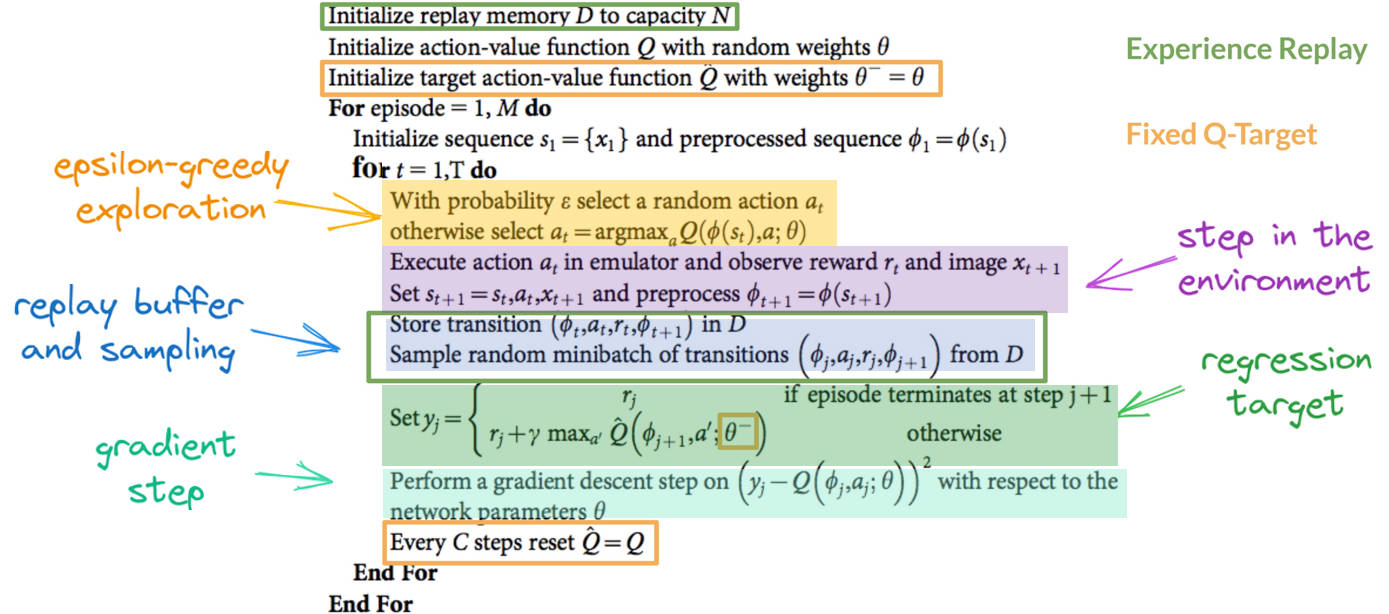
    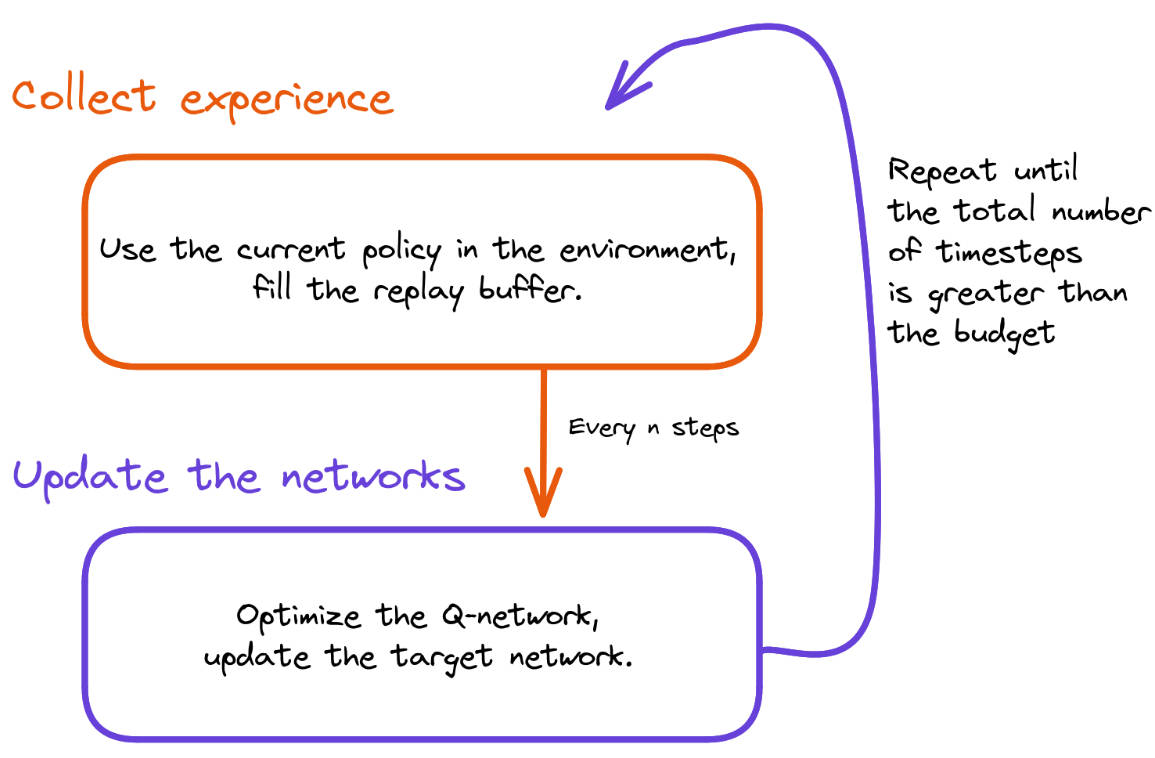
</div>

## 3.1 DQN中的一步参数更新
从上面的伪代码中我们可以发现，DQN中最核心的步骤是对Q-Network的参数进行更新，对应的是伪代码中的这一部分：
<div style="text-align:center;">
    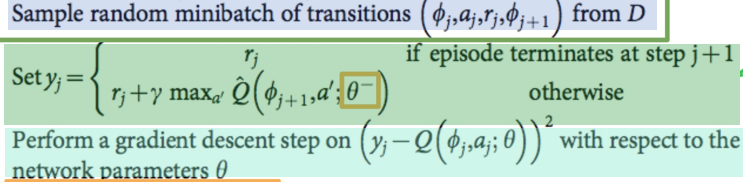
</div>

其中包含下面这几个步骤（大家可以对比之前的CNN、Transformer等作业中的监督学习训练流程）：
1. 从ReplayBuffer中采样一个batch的transitions（与之前监督学习中从dataloader中采样一个batch训练数据一样）
2. 根据公式计算这个batch数据的Q-Targets（这与之前监督学习有较大的区别，监督学习中数据已经包含了标签，但是强化学习中并没有标签，所以需要计算出一个优化的目标，我们称为Q-Targets，其计算公式见上图中$y_j$）
3. 用Q-Network对输入数据进行预测，得到Q-Estimations（与监督学习中的前向传播过程对应）
4. 计算预测值Q-Estimations和目标值Q-Targets之间的差异，并进行梯度更新（与监督学习中的反向传播和梯度更新对应）

下面我们需要编写这一部分的代码
### 代码填空5：一步更新（5分）

In [35]:
def one_step_update(
    q_net: QNetwork,
    q_target_net: QNetwork,
    optimizer: torch.optim.Optimizer,
    replay_buffer: ReplayBuffer,
    batch_size: int,
    gamma: float,
) -> None:
    """
    从ReplayBuffer中采样一个Batch的数据进行一步训练，并更新Q-Network的网络参数
    Args:
        q_net: Q-network, 参数需要更具梯度进行更新
        q_target_net: target Q-network, 用于计算Q-targets, 参数不需要更新
        optimizer: 优化器
        replay_buffer: 存有transitions的经验库，作用相当于数据集
        batch_size: 一个批量数据的大小
        gamma: 折扣回报的折扣率
    """
    ### YOUR CODE HERE >>>>>>>>>>>>>>>>>>
    # TODO-1. 从replay buffer采样一个批次的transitions作为训练数据
    # 提示：使用之前实现的ReplayBuffer.sample
    batch_transitions = replay_buffer.sample(batch_size)
    batch_transitions = batch_transitions.to_torch()
    
    # 从`batch_transitions`中解析出各项数据
    observations = batch_transitions.observations
    next_observations = batch_transitions.next_observations
    actions = batch_transitions.actions
    rewards = batch_transitions.rewards
    terminateds = batch_transitions.terminateds

    
    # 根据公式计算出 Q-targets 作为网络的预测目标, 计算公式如下
    # case 1: 如果回合结束了(即terminated=True)， q_target = reward
    # case 2: 否则，q_target = reward + gamma * max_a' Q_hat(s', a')
    # 其中Q_hat指target Q-Network; s'指transition中的next_obs; Q_hat(s', a')是next_obs下所有动作的价值
    with torch.no_grad():
        # TODO-2. 计算出下一状态的Q-values，即公式中的Q_hat(s', a')
        # 注意：使用Target Q-Network, 不是Q-Network!
        next_q_values = q_target_net(next_observations)
        
        # TODO-3. 按照greedy策略选出下一状态下价值最高的动作，即公式中的max_a' Q_hat(s', a')
        # 提示：使用torch.max(), 注意tensor.max(dim=..)返回一个元组(max_values, indices)
        max_next_q_values = next_q_values.max(dim=1)[0]
        
        # Qustion-1: Why?
        q_targets = rewards + gamma * max_next_q_values * torch.logical_not(terminateds)

    
    # TODO-3. 前向传播计算网络的预测值Q-Estimations, 形状(batch_size, action_dim)
    # 提示1：此处使用Q-Network，不是Target Q-Network
    # 提示2：此处是对当前状态obs进行预测，不是下一状态next_obs
    q_estimates = q_net(observations)

    ### END OF YOUR CODE <<<<<<<<<<<<<<<<<<

    # Qustion-2: Why? 
    q_estimates = torch.gather(q_estimates, dim=1, index=actions)
    # 调整形状从 (batch_size, 1) 到 (batch_size,)
    q_estimates = q_estimates.squeeze(dim=1)

    # 检查维度
    assert q_estimates.shape == (batch_size,)
    assert q_estimates.shape == q_targets.shape

    # 计算预测值和目标值之间的损失，此处使用的是MSE Loss
    loss = ((q_estimates - q_targets) ** 2).mean()

    # 进行梯度更新
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### 代码问答（2分）
请解释上面代码中的两个问题，每题1分（直接在下面的代码块中回答即可）\
**问题1**： \
`q_targets = rewards + gamma * max_next_q_values * torch.logical_not(terminateds)` \
请解释上面这行代码，是如何计算出q_targets的？其中torch.logical_not()请参考[API](https://pytorch.org/docs/stable/generated/torch.logical_not.html)

**问题2**：\
`q_estimates = torch.gather(q_estimates, dim=1, index=actions)` \
请解释上面这行代码，为什么需要进行该操作？其中torch.gather()请参考[API](https://pytorch.org/docs/stable/generated/torch.gather.html)

In [40]:
"""
回答1：
这行代码计算Q-targets，用于训练Q-Network的目标值。具体过程如下：
1. `rewards` 是执行当前动作后的即时奖励。
2. `gamma` 是折扣因子，用于衰减未来奖励的影响。
3. `max_next_q_values` 是所有可能动作的Q值中的最大值。
4. `terminateds` 指示每个样本是否为回合结束。
5. `torch.logical_not(terminateds)` :对于没有终止的状态为True，已终止的状态为False。
6. 当回合未结束时，`torch.logical_not(terminateds)` 为True，`gamma * max_next_q_values` 被保留，计算公式为 `reward + gamma * max_next_q_values`。
7. 当回合结束时，`torch.logical_not(terminateds)` 为False，`gamma * max_next_q_values` 被置零，计算公式为 `reward`。
通过这种方式，Q-targets 对于未结束的回合考虑了未来奖励，而对于已结束的回合只考虑即时奖励。


回答2：
这行代码从Q-Network的输出中选取执行的动作对应的Q值。具体过程如下：
1. `q_estimates` 是Q-Network对当前状态所有可能动作的Q值估计
2. `actions` 是实际执行的动作
3. `torch.gather(q_estimates, dim=1, index=actions)` 从 `q_estimates` 中沿着维度 `dim=1`（动作维度）选择 `actions` 索引处的值。
4. 结果是每个样本的实际执行动作的Q值。
需要进行该操作的原因是：Q-Network输出的是所有动作的Q值，但我们只关心实际执行的动作对应的Q值，用于计算与Q-targets之间的损失。


"""

'\n回答1：\n这行代码计算Q-targets，用于训练Q-Network的目标值。具体过程如下：\n1. `rewards` 是执行当前动作后的即时奖励。\n2. `gamma` 是折扣因子，用于衰减未来奖励的影响。\n3. `max_next_q_values` 是在下一个状态中选择所有可能动作的Q值中的最大值。\n4. `terminateds` 是一个布尔张量，指示每个样本是否为回合结束。\n5. `torch.logical_not(terminateds)` 将终止标志取反，产生一个布尔张量，对于没有终止的状态为True，已终止的状态为False。\n6. 当回合未结束时，`torch.logical_not(terminateds)` 为True，`gamma * max_next_q_values` 被保留，计算公式为 `reward + gamma * max_next_q_values`。\n7. 当回合结束时，`torch.logical_not(terminateds)` 为False，`gamma * max_next_q_values` 被置零，计算公式为 `reward`。\n通过这种方式，Q-targets 对于未结束的回合考虑了未来奖励，而对于已结束的回合只考虑即时奖励。\n\n\n回答2：\n这行代码从Q-Network的输出中选取执行的动作对应的Q值。具体过程如下：\n1. `q_estimates` 是Q-Network对当前状态所有可能动作的Q值估计，形状为 `(batch_size, action_dim)`。\n2. `actions` 是实际执行的动作，形状为 `(batch_size, 1)`，表示每个样本对应的动作索引。\n3. `torch.gather(q_estimates, dim=1, index=actions)` 从 `q_estimates` 中沿着维度 `dim=1`（动作维度）选择 `actions` 索引处的值。\n4. 结果是一个形状为 `(batch_size, 1)` 的张量，包含每个样本的实际执行动作的Q值。\n需要进行该操作的原因是：Q-Network输出的是所有动作的Q值，但我们只关心实际执行的动作对应的Q值，用于计算与Q-targets之间的损失。\n\n\n'

## 3.2 DQN的完整代码
### 代码填空6：添加注释（3分）
下面的函数`run_dqn_train_loop`已经编写完成，请大家在指定位置添加注释，以体现你对该代码的理解。共需添加8条注释，可回顾DQN的整体流程伪代码(上面给出的两个图)

In [36]:
def run_dqn_train_loop(
    env_id: str = "CartPole-v1",
    replay_buffer_size: int = 50_000,
    target_network_update_interval: int = 1000,
    learning_starts: int = 100,
    exploration_initial_eps: float = 1.0,
    exploration_final_eps: float = 0.01,
    exploration_fraction: float = 0.1,
    n_timesteps: int = 20_000,
    update_interval: int = 2,
    learning_rate: float = 3e-4,
    batch_size: int = 64,
    gamma: float = 0.99,
    n_hidden_units: int = 64,
    n_eval_episodes: int = 10,
    evaluation_interval: int = 1000,
    eval_exploration_rate: float = 0.0,
    seed: int = 2024,
    eval_render_mode: Optional[str] = None,
) -> QNetwork:
    """
    在给定的环境上运行DQN算法，并返回学到的Q-Network
    Args:
        env_id: 游戏环境的名称
        replay_buffer_size: ReplayBuffer的容量
        target_network_update_interval: 隔多少步更新一次target Q-Network(从Q-Network拷贝)
        learning_starts: 前面一些step用于积累transitions，不进行梯度更新，称作热身阶段
        n_timesteps: 训练的总步数
        update_interval: 隔多少步对Q-network的参数进行一次优化更新
        learning_rate: 学习率
        batch_size: 批次大小
        gamma: 折扣回报率
    """
    # 记录训练中间数据
    steps = []
    reward_means = []
    reward_stds = []
    
    # 固定随机数种子
    np.random.seed(seed)
    torch.manual_seed(seed)

    # 创建训练环境
    env = gym.make(env_id)
    env = gym.wrappers.FlattenObservation(env)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    assert isinstance(env.observation_space, spaces.Box)
    assert isinstance(env.action_space, spaces.Discrete)
    env.action_space.seed(seed)

    # 创建测试环境
    eval_env = gym.make(env_id, render_mode=eval_render_mode)
    eval_env = gym.wrappers.FlattenObservation(eval_env)
    eval_env.reset(seed=seed)
    eval_env.action_space.seed(seed)

    # 代码注释1: 创建Q-Network和Target Q-Network
    q_net = QNetwork(env.observation_space, env.action_space, n_hidden_units=n_hidden_units)
    q_target_net = QNetwork(env.observation_space, env.action_space, n_hidden_units=n_hidden_units)
    
    # 代码注释2: 将Target Q-Network的参数初始化为与Q-Network相同
    q_target_net.load_state_dict(q_net.state_dict())

    # 对于flappy bird环境需要有些额外操作
    if env.observation_space.dtype == np.float64:
        q_net.double()
        q_target_net.double()

    # 代码注释3: 创建优化器，用于优化Q-Network的参数
    # 提示：重点说明optimizer对哪些参数进行优化，以及为什么
    optimizer = torch.optim.Adam(q_net.parameters(), lr=learning_rate)

    # 代码注释4: 创建经验重放缓冲区，用于存储transitions
    replay_buffer = ReplayBuffer(replay_buffer_size, env.observation_space, env.action_space)
    
    # 开始循环，逐步训练
    obs, _ = env.reset(seed=seed)
    for current_step in tqdm(range(1, n_timesteps + 1)):
        # 代码注释5: 根据当前步数计算探索率epsilon，逐步减少探索率
        exploration_rate = linear_schedule(
            exploration_initial_eps,
            exploration_final_eps,
            current_step,
            int(exploration_fraction * n_timesteps),
        )

        # 代码注释6: 收集一个transition，并存入ReplayBuffer
        obs = collect_one_transition(
            env,
            q_net,
            replay_buffer,
            obs,
            exploration_rate=exploration_rate)

        # 代码注释7: 每隔一定步数，将Q-Network的参数复制到Target Q-Network
        if (current_step % target_network_update_interval) == 0:
            q_target_net.load_state_dict(q_net.state_dict())

        # 代码注释8: 每隔一定步数，从ReplayBuffer采样一个batch进行梯度更新
        if (current_step % update_interval) == 0 and current_step > learning_starts:
            one_step_update(q_net, q_target_net, optimizer, replay_buffer, batch_size, gamma=gamma)
        
        # 在训练过程中验证
        if (current_step % evaluation_interval) == 0 and current_step > learning_starts:
            reward_mean, reward_std = evaluate_policy(eval_env,
                                                      q_net,
                                                      n_eval_episodes,
                                                      epsilon_greedy_action_selection=epsilon_greedy_action_selection,
                                                      eval_exploration_rate=eval_exploration_rate)
            progress = current_step / (n_timesteps + 1) * 100
            print(f"[{current_step} / {n_timesteps + 1}](已完成：{progress:.2f}%) epsilon={exploration_rate:.2f} 平均reward: {reward_mean:.2f}±{reward_std:.2f}")
            steps.append(current_step)
            reward_means.append(reward_mean)
            reward_stds.append(reward_std)
            
    # 绘制训练的曲线图
    plt.figure(figsize=(4, 4))
    plt.plot(steps, reward_means, label='Reward Means', marker='o')
    plt.plot(steps, reward_stds, label='Reward Stds', marker='*')
    plt.title('Training Progress')
    plt.xlabel('Steps')
    plt.ylabel('Values')
    plt.legend()
    plt.show()
        
    return q_net

# 4.在游戏环境中实践DQN
现在我们已经实现了DQN的所有代码，接下来我们将在几个游戏环境中来实践之前的DQN。同时，通过观察训练是否收敛也可以检查你之前填写的代码是否正确

**说明：**
* 这一部分没有分数，但是大家**必须运行下面的代码**，按照设置好的参数训练即可；
* 如果下面代码跑不起来或者模型无法收敛，说明你前面的代码可能存在问题；
* 大家可以查看作业PPT中提供的参考训练结果，来对照自己的模型收敛情况是否正常。

## 4.1 训练DQN
请直接运行下面代码进行训练即可，超参已经设置好了

  6%|▋         | 5128/80000 [00:04<02:15, 553.42it/s] 

[5000 / 80001](已完成：6.25%) epsilon=0.40 平均reward: 262.30±49.95


 13%|█▎        | 10165/80000 [00:10<02:47, 417.14it/s]

[10000 / 80001](已完成：12.50%) epsilon=0.04 平均reward: 352.90±92.31


 19%|█▉        | 15136/80000 [00:16<01:59, 540.67it/s]

[15000 / 80001](已完成：18.75%) epsilon=0.04 平均reward: 251.80±49.30


 25%|██▌       | 20124/80000 [00:22<01:49, 548.85it/s]

[20000 / 80001](已完成：25.00%) epsilon=0.04 平均reward: 188.10±31.47


 31%|███▏      | 25174/80000 [00:28<01:36, 568.70it/s]

[25000 / 80001](已完成：31.25%) epsilon=0.04 平均reward: 211.70±19.51


 38%|███▊      | 30150/80000 [00:34<01:35, 522.30it/s]

[30000 / 80001](已完成：37.50%) epsilon=0.04 平均reward: 220.10±19.25


 44%|████▍     | 35086/80000 [00:40<01:29, 499.34it/s]

[35000 / 80001](已完成：43.75%) epsilon=0.04 平均reward: 287.50±14.93


 50%|█████     | 40142/80000 [00:47<01:41, 393.93it/s]

[40000 / 80001](已完成：50.00%) epsilon=0.04 平均reward: 500.00±0.00


 56%|█████▋    | 45176/80000 [00:53<01:20, 433.19it/s]

[45000 / 80001](已完成：56.25%) epsilon=0.04 平均reward: 395.30±128.86


 63%|██████▎   | 50170/80000 [00:59<01:13, 405.79it/s]

[50000 / 80001](已完成：62.50%) epsilon=0.04 平均reward: 445.60±110.12


 69%|██████▉   | 55156/80000 [01:06<01:07, 368.73it/s]

[55000 / 80001](已完成：68.75%) epsilon=0.04 平均reward: 500.00±0.00


 75%|███████▌  | 60100/80000 [01:12<00:56, 352.71it/s]

[60000 / 80001](已完成：75.00%) epsilon=0.04 平均reward: 500.00±0.00


 81%|████████▏ | 65120/80000 [01:18<00:39, 377.12it/s]

[65000 / 80001](已完成：81.25%) epsilon=0.04 平均reward: 500.00±0.00


 88%|████████▊ | 70178/80000 [01:25<00:25, 385.01it/s]

[70000 / 80001](已完成：87.50%) epsilon=0.04 平均reward: 500.00±0.00


 94%|█████████▍| 75152/80000 [01:31<00:13, 355.92it/s]

[75000 / 80001](已完成：93.75%) epsilon=0.04 平均reward: 500.00±0.00


100%|██████████| 80000/80000 [01:38<00:00, 813.70it/s]

[80000 / 80001](已完成：100.00%) epsilon=0.04 平均reward: 500.00±0.00


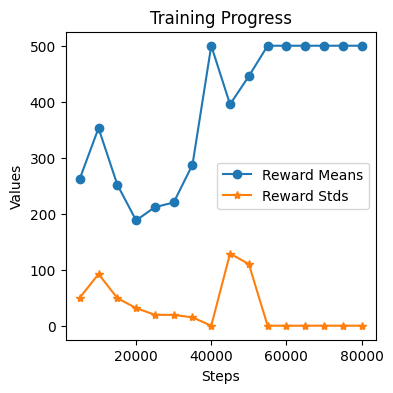

In [37]:
trained_q_net_cartpole = run_dqn_train_loop(
    env_id="CartPole-v1",
    replay_buffer_size=100_000,
    target_network_update_interval=10,
    learning_starts=1000,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.04,
    exploration_fraction=0.1,
    n_timesteps=80_000,
    update_interval=2,
    learning_rate=1e-3,
    batch_size=64,
    gamma=0.99,
    n_eval_episodes=10,
    evaluation_interval=5000,
    eval_exploration_rate=0.0,
    seed=2024)


## 4.2 测试训练好的模型
下面的代码会将你训练好的DQN用于游戏环境，并将智能体与环境交互的过程记录为视频以供展示。 \
**需要运行下面这个代码显示游戏视频，提交时需包含此项输出！**

游戏视频已经存储到：./dqn_cartpole.gif
在测试中您的智能体一共交互了:500步，累积得到奖励:500.00


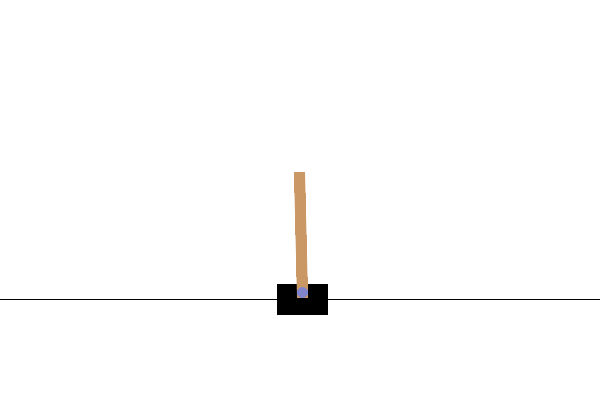

<Figure size 640x480 with 0 Axes>

In [38]:
# 与游戏交互并记录视频
cartpole_eval_env = gym.make('CartPole-v1', render_mode="rgb_array")
cartpole_eval_env = gym.wrappers.FlattenObservation(cartpole_eval_env)
record_video(eval_env=cartpole_eval_env,
              q_net=trained_q_net_cartpole,
              epsilon_greedy_action_selection=epsilon_greedy_action_selection,
              eval_exploration_rate=0.0,
              video_path='./dqn_cartpole.gif',
              fps=50)
# 显示游戏动图
show_video('./dqn_cartpole.gif')

## 4.3 保存模型参数
请运行下面代码保存训练好的Q-Network参数，**记得从kaggle下载到本地保存**，后续被抽到的同学需要提交此模型文件

In [39]:
torch.save(trained_q_net_cartpole, './dqn_qnetwork_cartpole.pth')
print('模型已存储至：./dqn_qnetwork_cartpole.pth')

模型已存储至：./dqn_qnetwork_cartpole.pth


***********

# 5. 拓展：尝试其他游戏环境
以下的内容不计分，感兴趣的同学可以尝试使用DQN算法玩其他游戏，不做这一部分也不会扣分
## 5.1 LunarLander

In [ ]:
# 准备环境
!pip install swig > /dev/null 2>&1
!pip install gymnasium[box2d] > /dev/null 2>&1

In [ ]:
# 训练
trained_q_net_LunarLander = run_dqn_train_loop(
        env_id="LunarLander-v2",
        replay_buffer_size=50_000,
        target_network_update_interval=250,
        learning_starts=100,
        exploration_initial_eps=1.0,
        exploration_final_eps=0.1,
        exploration_fraction=0.12,
        n_timesteps=100_000,
        update_interval=2,
        learning_rate=6e-4,
        batch_size=128,
        gamma=0.99,
        n_eval_episodes=10,
        evaluation_interval=10000,
        eval_exploration_rate=0.0,
        seed=2024,
    )
# 测试
LunarLander_env = gym.make('LunarLander-v2', render_mode="rgb_array")
LunarLander_env = gym.wrappers.FlattenObservation(LunarLander_env)
record_video(eval_env=LunarLander_env,
              q_net=trained_q_net_LunarLander,
              epsilon_greedy_action_selection=epsilon_greedy_action_selection,
              eval_exploration_rate=0.0,
              video_path='./dqn_LunarLander.gif')
# 显示游戏动图
show_video('./dqn_LunarLander.gif')

## 5.2 FlappyBird

In [ ]:
# 准备环境
!pip install flappy-bird-gymnasium > /dev/null 2>&1
import flappy_bird_gymnasium

In [ ]:
# 训练
trained_q_net_bird = run_dqn_train_loop(
    env_id="FlappyBird-v0",
    replay_buffer_size=100_000,
    target_network_update_interval=250,
    learning_starts=10_000,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.03,
    exploration_fraction=0.1,
    n_timesteps=500_000,
    update_interval=4,
    learning_rate=1e-3,
    batch_size=128,
    gamma=0.98,
    n_eval_episodes=5,
    evaluation_interval=10_000,
    n_hidden_units=256,
    eval_exploration_rate=0.0,
    seed=2024,
    eval_render_mode=None,)
# 测试
FlappyBird_env = gym.make('FlappyBird-v0', render_mode="rgb_array")
FlappyBird_env = gym.wrappers.FlattenObservation(FlappyBird_env)
record_video(eval_env=FlappyBird_env,
              q_net=trained_q_net_bird,
              epsilon_greedy_action_selection=epsilon_greedy_action_selection,
              eval_exploration_rate=0.0,
              video_path='./dqn_FlappyBird.gif')
# 显示游戏动图
show_video('./dqn_FlappyBird.gif')